In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

# Przygotowanie danych

Odczyt danych w których pozostawiliśmy tylko Warszawę i Lisbonę (edycja w Excel)

In [2]:
data_path_warsaw_lisbon = 'warsawlisbon.csv'
warsaw_lisbon_data = pd.read_csv(data_path_warsaw_lisbon)

warsaw_lisbon_data.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Europe,Poland,NaN,Warsaw,1,1,1995,35.4
1,Europe,Poland,NaN,Warsaw,1,2,1995,30.5
2,Europe,Poland,NaN,Warsaw,1,3,1995,27.2
3,Europe,Poland,NaN,Warsaw,1,4,1995,22.9
4,Europe,Poland,NaN,Warsaw,1,5,1995,18.7


Na tym etapie stwierdzamy, że `Region`, `Country` i `State` nie są nam potrzebne

In [3]:
warsaw_lisbon_data = warsaw_lisbon_data.drop('Region', axis=1)
warsaw_lisbon_data = warsaw_lisbon_data.drop('Country', axis=1)
warsaw_lisbon_data = warsaw_lisbon_data.drop('State', axis=1)

warsaw_lisbon_data

,City,Month,Day,Year,AvgTemperature
0,Warsaw,1,1,1995,35.4
1,Warsaw,1,2,1995,30.5
2,Warsaw,1,3,1995,27.2
3,Warsaw,1,4,1995,22.9
4,Warsaw,1,5,1995,18.7
...,...,...,...,...,...
18527,Lisbon,5,9,2020,59.8
18528,Lisbon,5,10,2020,60.0
18529,Lisbon,5,11,2020,60.3
18530,Lisbon,5,12,2020,59.6


`Month`, `Day`, `Year` i `AvgTemperature` to liczby

In [4]:
warsaw_lisbon_data["Month"] = pd.to_numeric(warsaw_lisbon_data["Month"])
warsaw_lisbon_data["Day"] = pd.to_numeric(warsaw_lisbon_data["Day"])
warsaw_lisbon_data["Year"] = pd.to_numeric(warsaw_lisbon_data["Year"])
warsaw_lisbon_data["AvgTemperature"] = pd.to_numeric(warsaw_lisbon_data["AvgTemperature"])

Dzielimy dane na miasta i sortujemy datą

In [5]:
warsaw_data = warsaw_lisbon_data.copy()[warsaw_lisbon_data.City == 'Warsaw']
lisbon_data = warsaw_lisbon_data.copy()[warsaw_lisbon_data.City == 'Lisbon']

warsaw_data['Date'] = pd.to_datetime(warsaw_data[['Year', 'Month', 'Day']])
lisbon_data['Date'] = pd.to_datetime(lisbon_data[['Year', 'Month', 'Day']])

warsaw_data = warsaw_data.sort_values(by='Date')
lisbon_data = lisbon_data.sort_values(by='Date')

Natomiast po takim podziale, zauważmy że występuje problem z numeracją wierszy

In [6]:
lisbon_data.head()

,City,Month,Day,Year,AvgTemperature,Date
9266,Lisbon,1,1,1995,53.5,1995-01-01
9267,Lisbon,1,2,1995,46.9,1995-01-02
9268,Lisbon,1,3,1995,45.8,1995-01-03
9269,Lisbon,1,4,1995,53.3,1995-01-04
9270,Lisbon,1,5,1995,56.2,1995-01-05


Poprawmy go

In [7]:
lisbon_data.reset_index(drop=True, inplace=True)
lisbon_data.head()

,City,Month,Day,Year,AvgTemperature,Date
0,Lisbon,1,1,1995,53.5,1995-01-01
1,Lisbon,1,2,1995,46.9,1995-01-02
2,Lisbon,1,3,1995,45.8,1995-01-03
3,Lisbon,1,4,1995,53.3,1995-01-04
4,Lisbon,1,5,1995,56.2,1995-01-05


Zobaczmy jak dane się prezentują na wykresie

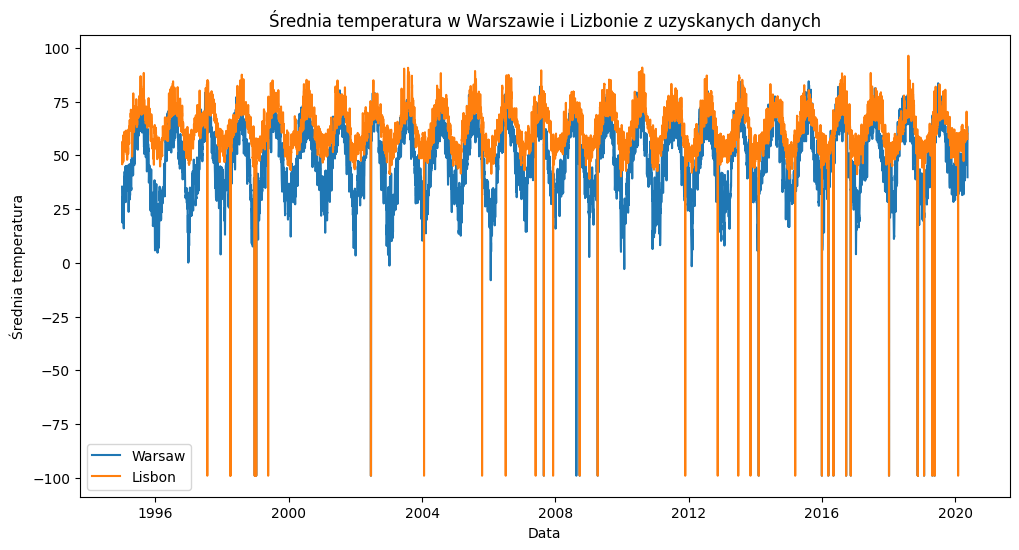

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(warsaw_data['Date'], warsaw_data['AvgTemperature'], label='Warsaw')
plt.plot(lisbon_data['Date'], lisbon_data['AvgTemperature'], label='Lisbon')

plt.title('Średnia temperatura w Warszawie i Lizbonie z uzyskanych danych')

plt.xlabel('Data')
plt.ylabel('Średnia temperatura')

plt.legend()
plt.show()

Widzimy teraz pewne problemy. W uzyskanych danych badacze nie zmierzeli danych dla wybranych konkretnych przypadkowych dni co powoduje problem.

Dodatkowo temperatura jest prawdopodobnie w Farenheitach 

In [9]:
lisbon_data[lisbon_data.AvgTemperature < -75].head()

,City,Month,Day,Year,AvgTemperature,Date
934,Lisbon,7,23,1997,-99.0,1997-07-23
1184,Lisbon,3,30,1998,-99.0,1998-03-30
1189,Lisbon,4,4,1998,-99.0,1998-04-04
1190,Lisbon,4,5,1998,-99.0,1998-04-05
1453,Lisbon,12,24,1998,-99.0,1998-12-24


Potwierdza się hipoteza, `-99` to wartość kiedy prawdopodobnie temp. nie została zmierzona bo mija się to z prawdą. Zmienimy je na średnią z 5 sasiądujących dni.
`brakujący dzień = 1/4 (-2 dzień + -1 dzień + +1 dzień + +2dzień)`

In [10]:
lisbon_data['AvgTemperature_New'] = lisbon_data['AvgTemperature']

for i in range(len(lisbon_data)):
    if lisbon_data.at[i, 'AvgTemperature'] == -99.0:
        start_index = max(0, i - 2)
        end_index = min(len(lisbon_data), i + 2)
        neighbors = lisbon_data['AvgTemperature'].loc[start_index:end_index]
        neighbors_without_minus_99 = neighbors[neighbors != -99.0]
        lisbon_data.at[i, 'AvgTemperature_New'] = round(neighbors_without_minus_99.mean(), 2)

lisbon_data['AvgTemperature'] = lisbon_data['AvgTemperature_New']
lisbon_data = lisbon_data.drop('AvgTemperature_New', axis=1)

lisbon_data[lisbon_data.AvgTemperature < -75].head()

,City,Month,Day,Year,AvgTemperature,Date


Puste wiersze z złymi danymi => więc się zgadza. To samo robimy dla Warszawy.

In [11]:
warsaw_data[warsaw_data.AvgTemperature < -75].head()

,City,Month,Day,Year,AvgTemperature,Date
1453,Warsaw,12,24,1998,-99.0,1998-12-24
1454,Warsaw,12,25,1998,-99.0,1998-12-25
1459,Warsaw,12,30,1998,-99.0,1998-12-30
1460,Warsaw,12,31,1998,-99.0,1998-12-31
1470,Warsaw,1,10,1999,-99.0,1999-01-10


In [12]:
warsaw_data['AvgTemperature_New'] = warsaw_data['AvgTemperature']

for i in range(len(warsaw_data)):
    if warsaw_data.at[i, 'AvgTemperature'] == -99.0:
        start_index = max(0, i - 2)
        end_index = min(len(lisbon_data), i + 2)
        neighbors = warsaw_data['AvgTemperature'].loc[start_index:end_index]
        neighbors_without_minus_99 = neighbors[neighbors != -99.0]
        warsaw_data.at[i, 'AvgTemperature_New'] = round(neighbors_without_minus_99.mean(), 2)

warsaw_data['AvgTemperature'] = warsaw_data['AvgTemperature_New']
warsaw_data = warsaw_data.drop('AvgTemperature_New', axis=1)

warsaw_data[warsaw_data.AvgTemperature < -75].head()

,City,Month,Day,Year,AvgTemperature,Date


Zobaczmy wykres po tych modyfikacjach

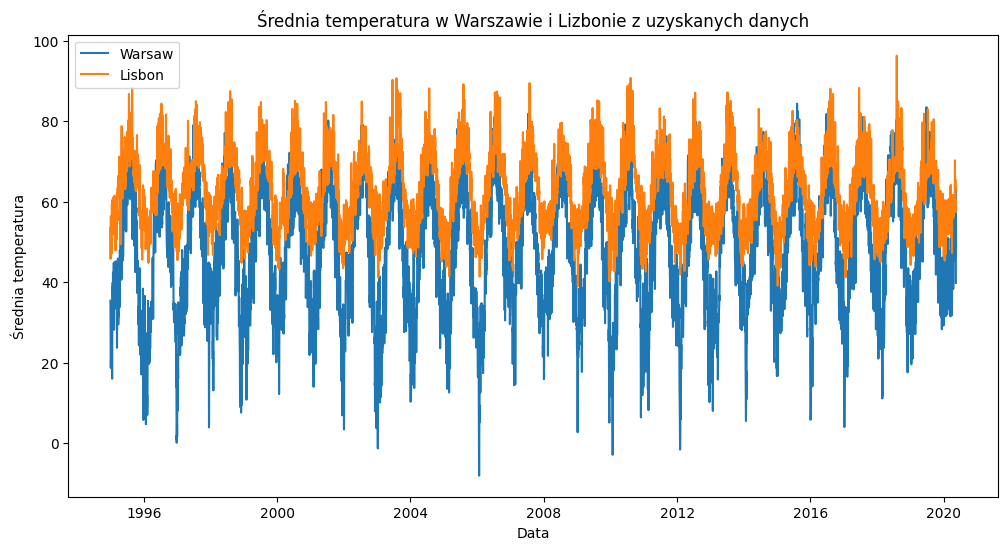

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(warsaw_data['Date'], warsaw_data['AvgTemperature'], label='Warsaw')
plt.plot(lisbon_data['Date'], lisbon_data['AvgTemperature'], label='Lisbon')

plt.title('Średnia temperatura w Warszawie i Lizbonie z uzyskanych danych')

plt.xlabel('Data')
plt.ylabel('Średnia temperatura')

plt.legend()
plt.show()

Wartośc są mniej niepokojące jednak 100 stopni nie jest możliwe. Zauważmy że $100$ stopni Farenheita to $37.7$ Celcjusza co miałoby większy sens ale maksimum.

Wzór konwersji z Farenheita na Celsjusza to:
$$
(F - 32) \cdot \frac{5}{9}
$$

In [14]:
def fahrenheit_to_celsius(fahrenheit):
    return (fahrenheit - 32) * (5/9)


warsaw_data['AvgTemperature'] = warsaw_data['AvgTemperature'].apply(fahrenheit_to_celsius)
lisbon_data['AvgTemperature'] = lisbon_data['AvgTemperature'].apply(fahrenheit_to_celsius)

Ponownie spójrzmy na wykres

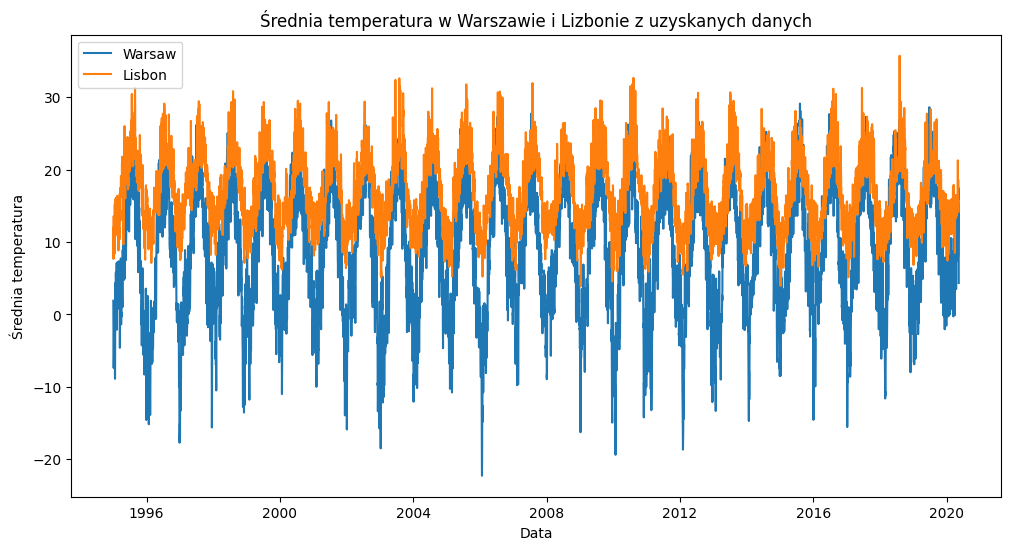

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(warsaw_data['Date'], warsaw_data['AvgTemperature'], label='Warsaw')
plt.plot(lisbon_data['Date'], lisbon_data['AvgTemperature'], label='Lisbon')

plt.title('Średnia temperatura w Warszawie i Lizbonie z uzyskanych danych')

plt.xlabel('Data')
plt.ylabel('Średnia temperatura')

plt.legend()
plt.show()

Takie dane wyglądają jak najbadziej sensownie i realnie - mamy więc z czym pracować.

Rozpocznijmy od zastosowania podstawowych pojęć statystycznych do tych danych

- Warszawa

In [16]:
warsaw_data['AvgTemperature'].describe()

count    9266.000000
mean        9.026345
std         8.719466
min       -22.277778
25%         2.277778
50%         9.222222
75%        16.222222
max        29.111111
Name: AvgTemperature, dtype: float64

- Lizbona

In [17]:
lisbon_data['AvgTemperature'].describe()

count    9266.000000
mean       17.011166
std         4.883680
min         3.888889
25%        13.111111
50%        16.777778
75%        20.722222
max        35.722222
Name: AvgTemperature, dtype: float64

# Analiza danych

Zacznijmy od poznania danych boxplotem

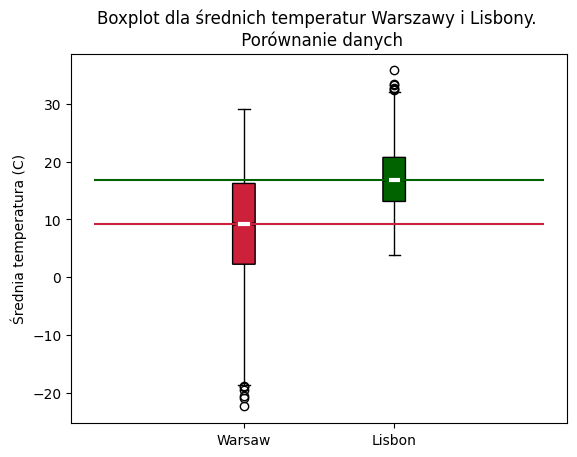

In [49]:
bp = plt.boxplot([warsaw_data.AvgTemperature, lisbon_data.AvgTemperature], patch_artist = True, notch ='True')

colors = ['#cd203b', '#006300']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# medians
for median in bp['medians']:
    median.set(color ='white',
               linewidth = 3)
            
plt.hlines(warsaw_data.AvgTemperature.median(), 0, 3, color=colors[0])
plt.hlines(lisbon_data.AvgTemperature.median(), 0, 3, color=colors[1])

plt.xticks([1, 2], ['Warsaw', 'Lisbon'])

plt.title('Boxplot dla średnich temperatur Warszawy i Lisbony. \n Porównanie danych')
plt.ylabel('Średnia temperatura (C)')

plt.show()

Tutaj zauważamy już dość sporo informacji o naszych danych:
- Średnia temperatury w Lizbonie jest znacząco wyższa niż w Warszawie. To sugeruje, że Lizbona ma cieplejszy klimat niż Warszawa.
- Zmienność temperatury w Warszawie jest znacznie większa niż w Lizbonie: Odchylenie standardowe dla Warszawy wynosi 8.72°C, podczas gdy dla Lizbony jest to 4.88°C.
- Średnia temperatura Lizbony przekracza trzeci kwartyl Warszawy. To sugeruje, że temperatura w Lizbonie jest ogólnie wyższa niż w Warszawie.

# Paranoje Matiego odnośnie tygodniowych średnich:

In [36]:
warsaw_data = warsaw_lisbon_data[warsaw_lisbon_data['City'] == 'Warsaw']
lisbon_data = warsaw_lisbon_data[warsaw_lisbon_data['City'] == 'Lisbon']
warsaw_data.set_index('Date', inplace=True)
lisbon_data.set_index('Date', inplace=True)

warsaw_weekly_avg = warsaw_data['AvgTemperature'].resample('W').mean()
lisbon_weekly_avg = lisbon_data['AvgTemperature'].resample('W').mean()

print("Warsaw weekly avg:", warsaw_weekly_avg.head())
print("Lisbon weekly avg:", lisbon_weekly_avg.head())


Warsaw weekly avg: Date
2019-01-06    31.116667
2019-01-13    26.342857
2019-01-20    32.828571
2019-01-27     6.714286
2019-02-03    34.685714
Freq: W-SUN, Name: AvgTemperature, dtype: float64
Lisbon weekly avg: Date
2019-01-06    48.083333
2019-01-13    48.800000
2019-01-20    50.728571
2019-01-27    31.828571
2019-02-03    52.714286
Freq: W-SUN, Name: AvgTemperature, dtype: float64


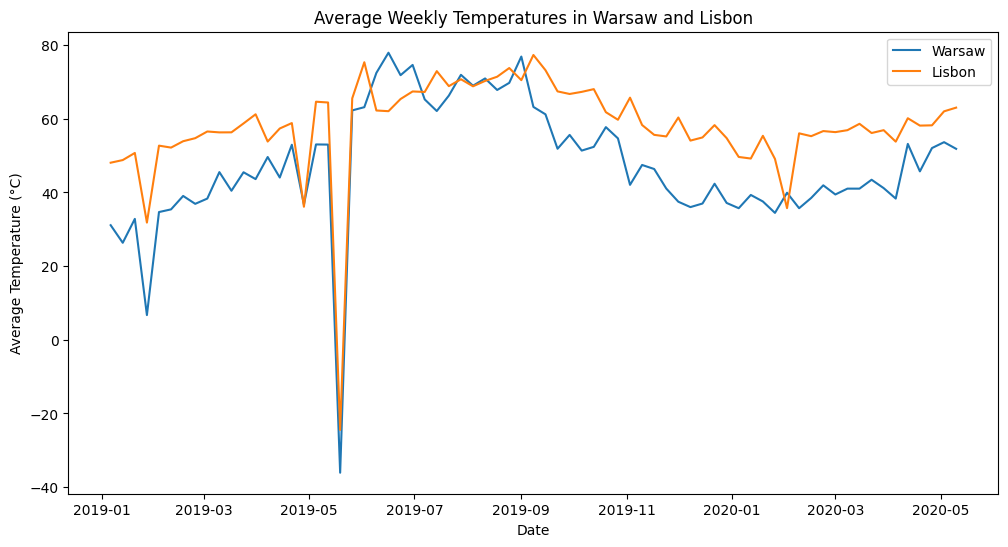

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(warsaw_weekly_avg.index, warsaw_weekly_avg, label='Warsaw')
plt.plot(lisbon_weekly_avg.index, lisbon_weekly_avg, label='Lisbon')
plt.title('Average Weekly Temperatures in Warsaw and Lisbon')
plt.xlabel('Date')
plt.ylabel('Average Temperature (°C)')
plt.legend()
plt.show()
